## TODO-List

#### Open Questions
- [  ] t-SNE with test or train samples?

#### Training
- [✅] MLP 
- [  ] Different Models / Datasets

#### Visualization
- [  ] Use ALL train data for PCA?
- [  ] UMAP
- [✅] PCA
- [-] Live during training

# Visualizing Embedding Evolution During Training

In this notebook, we train an MLP on MNIST and visualize how hidden representations (embeddings) evolve over training using t-SNE. This gives insight into how class structure emerges in the latent space over time.

In [1]:
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)  # Should print something like '11.8'
print("Using device:", device)

2.6.0+cu124
12.4
Using device: cuda


# Dataset
### MNIST

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#train_subset, _ = torch.utils.data.random_split(train_data, [10000, len(train_data)-10000])
#train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

### Test Subset for visualization

In [3]:
from torch.utils.data import Subset

# First, get all test labels
test_targets = test_data.targets.numpy()

# Define how many samples per class
samples_per_class = 100
num_classes = 10

# Collect indices (balanced subset)
selected_indices = []
for class_id in range(num_classes):
    class_indices = np.where(test_targets == class_id)[0]
    chosen = np.random.choice(class_indices, size=samples_per_class, replace=False)
    selected_indices.extend(chosen)

# Create a test subset DataLoader (shuffling not needed)
test_subset = Subset(test_data, selected_indices)
test_subset_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

In [4]:
print(len(train_data))
print(len(test_data))
print(len(test_subset))

60000
10000
1000


# Model
### MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_embedding=False):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        if return_embedding:
            return out, h
        return out

model_mlp = MLP().to(device)

In [6]:
print(f"{len(train_loader)} Batches")

469 Batches


##### Training
After 10 Epochs
| Embedding Dimension | Final Train Acc | Final Test Acc | Test Epoch 3 |
| ------------- | ------------- | ------------- | ------------- |
| 128 | 0.9897 | 0.9760 | 0.9610 |
| 64 | 0.9782 | **0.9706** | 0.9504 |
| 32 | 0.9678 | 0.9625 | 0.9428 |
| 16 | 0.9434 | 0.9398 | 0.9256 |

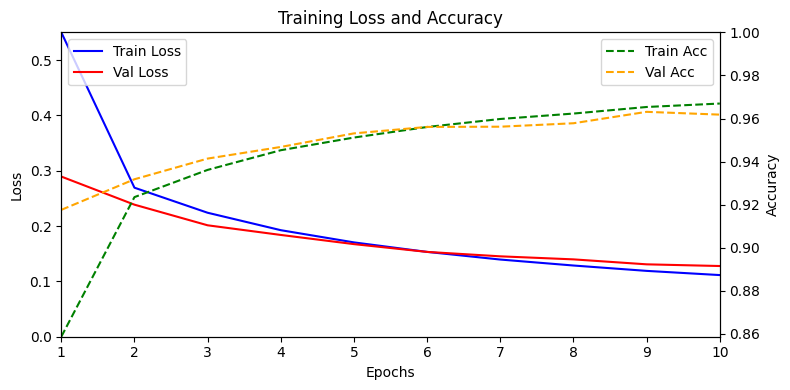

Epoch [1/10] | Train Loss: 0.5501, Acc: 0.8587 | Val Loss: 0.2894, Acc: 0.9176
Epoch [2/10] | Train Loss: 0.2693, Acc: 0.9235 | Val Loss: 0.2386, Acc: 0.9318
Epoch [3/10] | Train Loss: 0.2240, Acc: 0.9362 | Val Loss: 0.2014, Acc: 0.9414
Epoch [4/10] | Train Loss: 0.1925, Acc: 0.9453 | Val Loss: 0.1839, Acc: 0.9468
Epoch [5/10] | Train Loss: 0.1705, Acc: 0.9512 | Val Loss: 0.1673, Acc: 0.9531
Epoch [6/10] | Train Loss: 0.1533, Acc: 0.9561 | Val Loss: 0.1533, Acc: 0.9561
Epoch [7/10] | Train Loss: 0.1395, Acc: 0.9598 | Val Loss: 0.1453, Acc: 0.9562
Epoch [8/10] | Train Loss: 0.1287, Acc: 0.9623 | Val Loss: 0.1398, Acc: 0.9578
Epoch [9/10] | Train Loss: 0.1190, Acc: 0.9654 | Val Loss: 0.1308, Acc: 0.9631
Epoch [10/10] | Train Loss: 0.1114, Acc: 0.9669 | Val Loss: 0.1278, Acc: 0.9618
Recorded 50 embeddings in 10 epochs (5.00 per epoch).


In [44]:
%matplotlib inline

model_mlp = MLP(hidden_dim=32).to(device)
from train_viz import train_model_with_embedding_tracking

results = train_model_with_embedding_tracking(
    model=model_mlp,
    train_loader=train_loader,
    test_loader=test_loader,
    test_subset_loader=test_subset_loader,
    device=device,
    epochs=10,
    learning_rate=0.001,
    embedding_mode='batch',
    batch_interval=100 #47   ### Adjust to get a proper amout of embeddings per epoch
)

##    return {
##        'train_losses': train_losses,
##        'val_losses': val_losses,
##        'train_accuracies': train_accuracies,
##        'val_accuracies': val_accuracies,
##        'test_subset_embeddings': test_subset_embeddings,
##        'test_subset_labels': test_subset_labels
##    }

# Video Animation
New

In [45]:
from train_viz import generate_projections, animate_projections, show_with_slider, show_multiple_projections_with_slider

## PCA

In [46]:
projections_pca_first = generate_projections(
    embeddings_list=results["test_subset_embeddings"],
    method='pca',
    pca_fit_basis='first',
    max_frames=None
)
projections_pca_last = generate_projections(
    embeddings_list=results["test_subset_embeddings"],
    method='pca',
    pca_fit_basis='last',
    max_frames=None
)
projections_pca_all = generate_projections(
    embeddings_list=results["test_subset_embeddings"],
    method='pca',
    pca_fit_basis='all',
    max_frames=None
)

In [47]:
%matplotlib widget

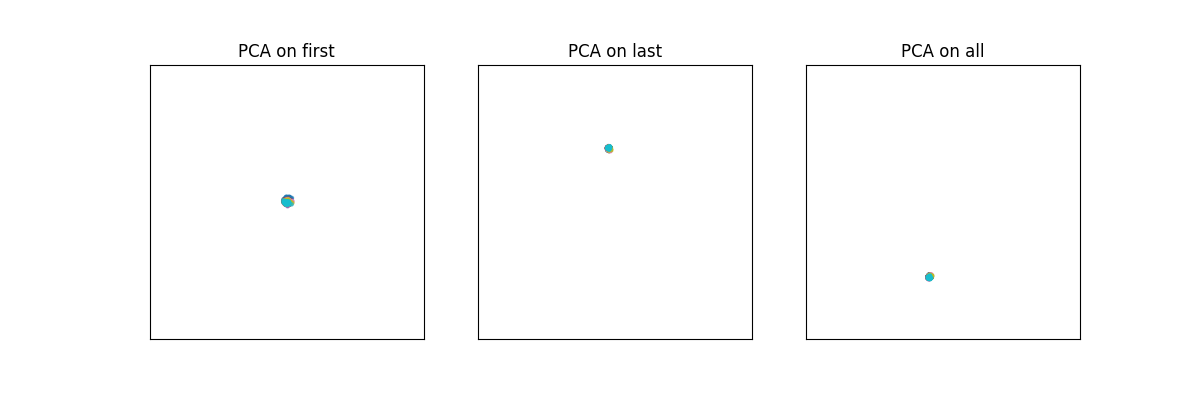

In [48]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_first, projections_pca_last, projections_pca_all],
    labels=results["test_subset_labels"],
    titles=["PCA on first", "PCA on last", "PCA on all"],
    interpolate=True,
    steps_per_transition=2,
    figsize_per_plot=(4, 4),
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


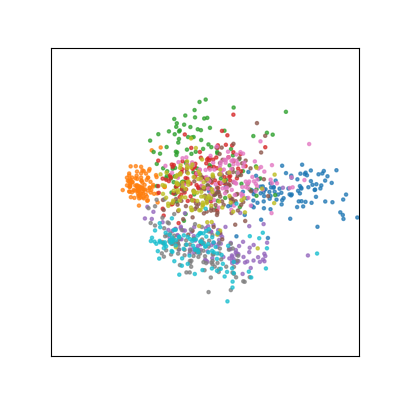

In [15]:
from IPython.display import HTML
ani_pca = animate_projections(
    projections_pca_all,
    labels=results["test_subset_labels"],
    interpolate=False,
    steps_per_transition=2
)
HTML(ani_pca.to_jshtml())

## tSNE

In [49]:
projections_tsne = generate_projections(
    embeddings_list=results["test_subset_embeddings"],
    method='tsne',
    max_frames=None
)

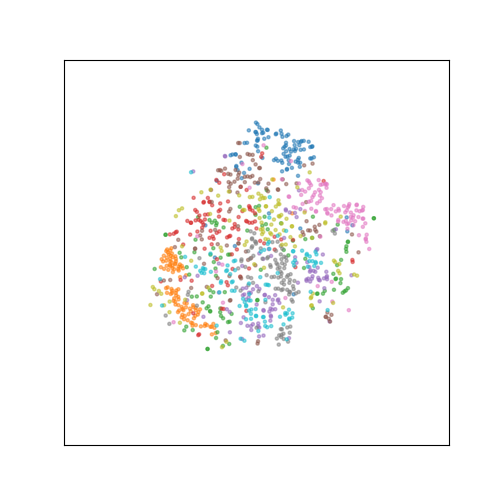

In [50]:
ani_tsne = show_with_slider(
    projections_tsne,
    labels=results["test_subset_labels"],
    interpolate=False,
)

## t-SNE Backwards (reverse computation)

In [51]:
projections_tsne_reverse = generate_projections_new(
    embeddings_list=results["test_subset_embeddings"],
    method='tsne',
    max_frames=None,
    reverse_computation=True
)

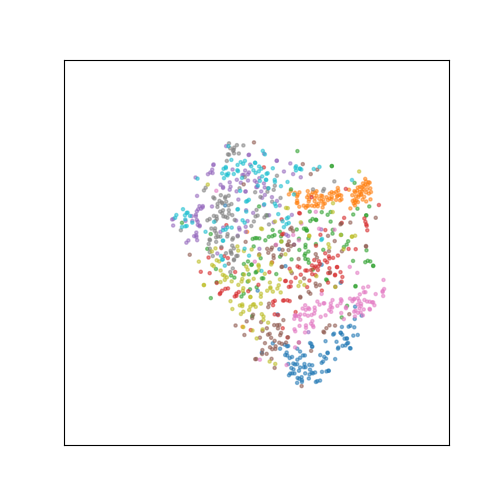

In [56]:
ani_tsne_reverse = show_with_slider(
    projections_tsne_reverse,
    labels=results["test_subset_labels"],
    interpolate=False,
)

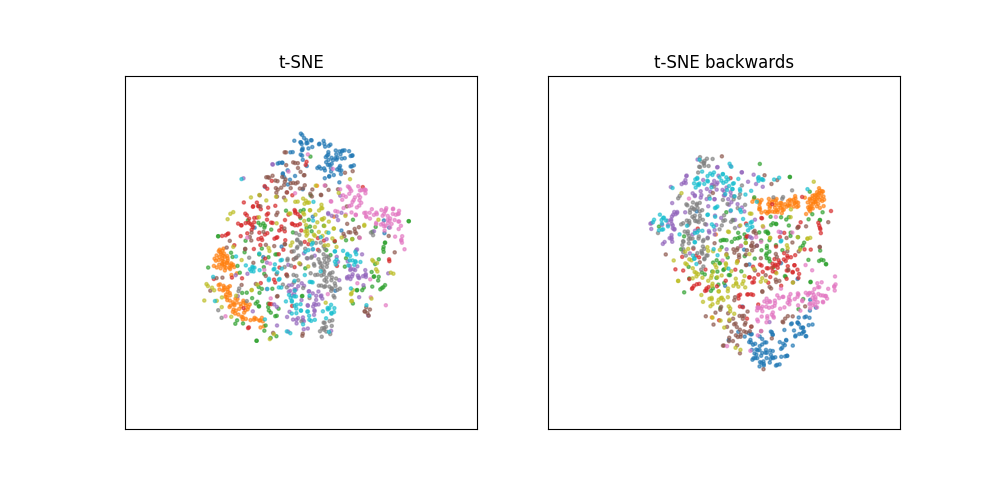

In [58]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_tsne_reverse],
    labels=results["test_subset_labels"],
    titles=["t-SNE", "t-SNE backwards"],
    interpolate=True,
    steps_per_transition=5,
    figsize_per_plot=(5, 5),
)

## t-SNE Seeds

In [54]:
projections_tsne_2 = generate_projections_new(
    embeddings_list=results["test_subset_embeddings"],
    method='tsne',
    max_frames=None,
    random_state=1106,
    tsne_init='random'
)

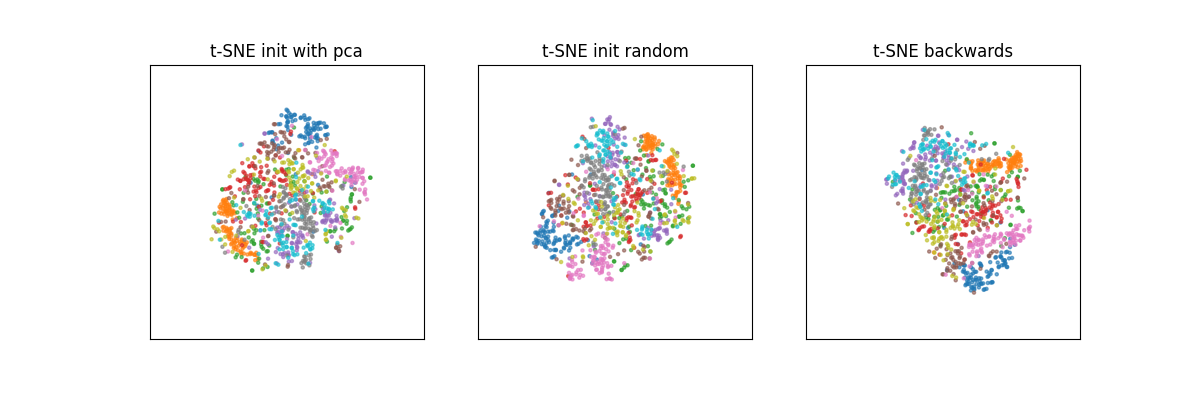

In [55]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_tsne_2, projections_tsne_reverse],
    labels=results["test_subset_labels"],
    titles=["t-SNE init with pca", "t-SNE init random", "t-SNE backwards"],
    interpolate=True,
    steps_per_transition=5,
    figsize_per_plot=(4, 4),
)

## t-SNE Perplexity
Compare 5 - 30 - 50

In [ ]:
# Todo

## t-SNE vs PCA

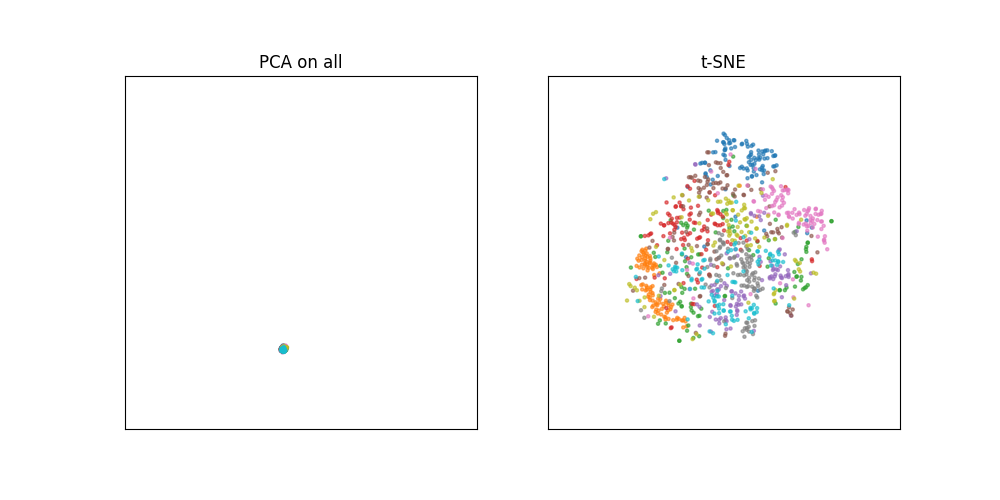

In [59]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_all, projections_tsne],
    labels=results["test_subset_labels"],
    titles=["PCA on all", "t-SNE"],
    interpolate=True,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

In [ ]:
# ani_tsne = animate_projections(
#     projections_tsne,
#     labels=results["test_subset_labels"],
#     interpolate=True,
#     steps_per_transition=2
# )
# HTML(ani_tsne.to_jshtml())

## UMAP
UMAP (Uniform Manifold Approximation and Projection) is a **faster** alternative to t-SNE that also **aims to preserve some global structure**.

In [61]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap = generate_projections(
        embeddings_list=results["test_subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        max_frames=None
    )

/home/crebmann/train-viz/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


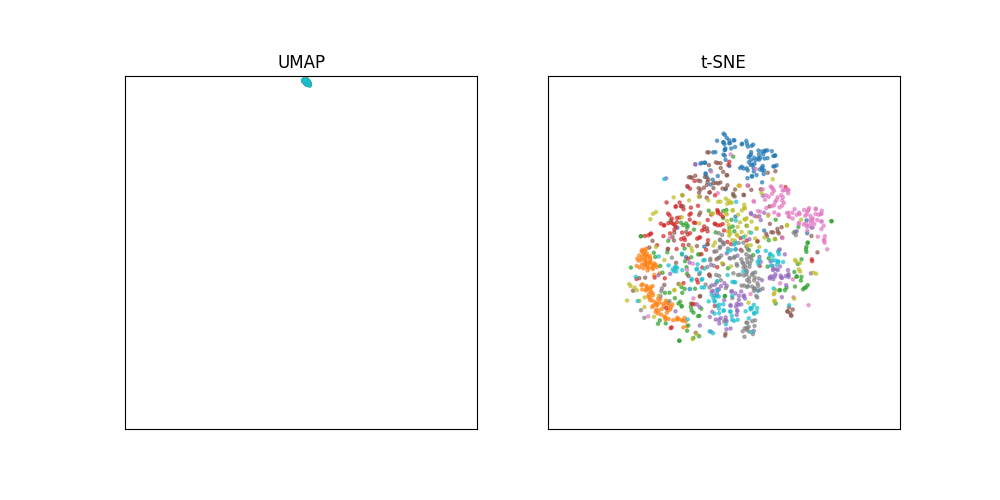

In [63]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap, projections_tsne],
    labels=results["test_subset_labels"],
    titles=["UMAP", "t-SNE"],
    interpolate=False,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

## UMAP Initialization
UMAP builds a graph-based representation of the data during `fit()`, learning the local and global structure (neighborhoods) in the `basis_data`. Once this structure is learned, it can be used to **transform new data** into the same low-dimensional space without retraining — unlike t-SNE, which must be refit every time.

This makes UMAP more efficient and suitable for dynamic or streaming embeddings.

IDEA: Fit not only on selection of test data?

In [66]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_first = generate_projections(
        embeddings_list=results["test_subset_embeddings"],
        method='umap',
        pca_fit_basis='first',
        max_frames=None
    )

In [68]:
# Todo: Middle







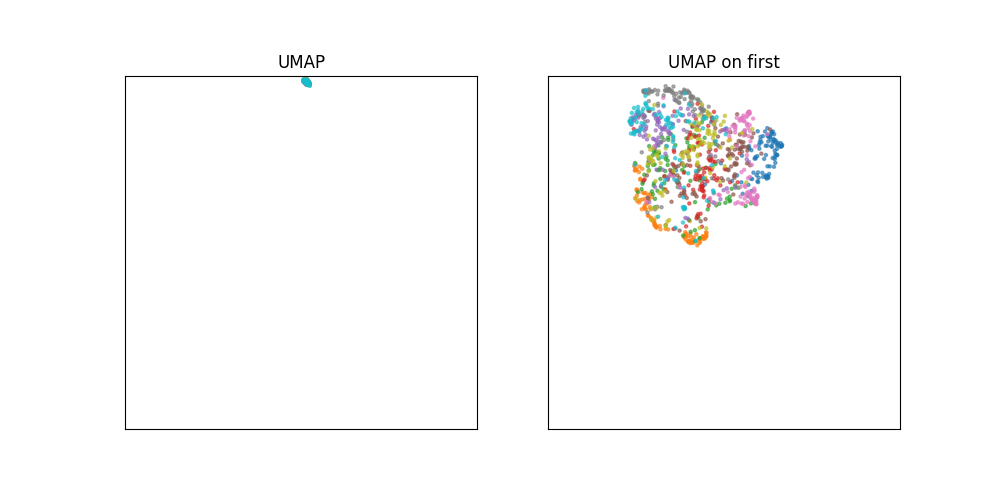

In [67]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap, projections_umap_first],
    labels=results["test_subset_labels"],
    titles=["UMAP", "UMAP on first"],
    interpolate=False,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

## UMAP Hyperparameters

In [ ]:
# Todo

# Video Export

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")

In [ ]:
import os

# === Define experiment info ===
model_name = model._get_name()
# Build a base name with settings
base_name = f"tsne_{model_name}_e{epochs}_lr{learning_rate:.0e}"  # e.g., tsne_MLP_e10_lr1e-03

# Auto-increment file index
i = 1
while os.path.exists(f"{base_name}_{i:03}.gif"):
    i += 1
filename = f"{base_name}_{i:03}.gif"

# Save the animation
ani.save(filename, writer='pillow')
print(f"Saved animation as {filename}")

# Video Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
import os

# === Interpolation between t-SNE results ===
def interpolate_tsne(embeddings_list, steps=10):
    interpolated = []
    for a, b in zip(embeddings_list[:-1], embeddings_list[1:]):
        for alpha in np.linspace(0, 1, steps, endpoint=False):
            interp = (1 - alpha) * a + alpha * b
            interpolated.append(interp)
    interpolated.append(embeddings_list[-1])  # include final frame
    return interpolated

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Subsequent epochs
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Interpolate between epochs ===
tsne_results_interp = interpolate_tsne(tsne_results, steps=5)

# === Animation setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title('t-SNE Embedding Evolution')

def update(frame):
    scatter.set_offsets(tsne_results_interp[frame])
    scatter.set_array(sampled_labels)
    title.set_text(f't-SNE Embedding Evolution – Frame {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results_interp), interval=100, blit=True)

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")